In [2]:
import essentia
import math
from essentia import *

import essentia.standard as std
import IPython.display as ipd
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt

import librosa
import scipy
from scipy import spatial, signal 
import warnings

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [5]:
def buscar_frecuencia(texto):
    frecuencias = [20, 30, 40, 60, 80, 120, 160, 240, 320, 480, 640, 960, 1280, 1920, 2560, 3840, 5120, 7680, 10240, 15360, 20480]
    voltajes = ["00.0", "00.5", "01.0", "01.5", "02.0", "02.5", "03.0", "03.5", "04.0", "04.5", "05.0", "05.5", "06.0", "06.5", "07.0", "07.5", "08.0", "08.5", "09.0", "09.5", "10.0"]
    for i, voltaje in enumerate(voltajes):
        if str(voltaje) in texto:
            print(voltaje)
            print(frecuencias[i])
            return frecuencias[i]
    return None


def similitud_coseno_MFCC(original, remake, sampleRate):
    original_mfcc = librosa.feature.mfcc(y=original,sr=sampleRate)
    syntesis_mfcc = librosa.feature.mfcc(y=remake,sr=sampleRate)

    n = syntesis_mfcc.shape[1]
    coss_sim = np.zeros(n)

    for i in range(n):
        original = original_mfcc[1:, i]
        syntesis = syntesis_mfcc[1:, i]
        coss_sim[i] = 1 - spatial.distance.cosine(original, syntesis)


    similitud_value = np.round(np.mean(coss_sim),4)
          
    return similitud_value

def comparar_frecuencias(audio1, audio2, fs):
    """
    Compara las diferencias en frecuencia entre dos señales de 
    audio utilizando la similitud del coseno.
    """
    if len(audio1) > len(audio2):
        audio1 = audio1[:len(audio2)]
    elif len(audio2) > len(audio1):
        audio2 = audio2[:len(audio1)]
    
    # Calcular la transformada de Fourier de cada señal
    fft_audio1 = librosa.stft(audio1)
    fft_audio2 = librosa.stft(audio2)

    # Calcular las magnitudes de las transformadas
    magnitud_audio1 = np.abs(fft_audio1)
    magnitud_audio2 = np.abs(fft_audio2)
    
    # Calcular la similitud del coseno entre las magnitudes
    similitud = 1 - spatial.distance.cosine(magnitud_audio1.flatten(), magnitud_audio2.flatten())

    return similitud

def compare_audio_MSE(audio1, audio2):
    """
    Compara dos señales de audio utilizando el método MSE (Mean Square Error).
    """
    
    if len(audio1) > len(audio2):
        audio1 = audio1[:len(audio2)]
    elif len(audio2) > len(audio1):
        audio2 = audio2[:len(audio1)]

    mse = np.round(np.mean(np.square(audio1 - audio2)), 6)

    return mse

def cut_audio_one_period(audio, sampleRate, file_name):
    
    freq_fund_teorica = buscar_frecuencia(file_name)
    
    # Realizar la transformada de Fourier
    fft = np.fft.fft(audio)

    # Obtener la amplitud de la transformada
    magnitude = np.abs(fft)

    f0 = librosa.yin(audio,
                 sr=sampleRate, 
                 fmin=round(freq_fund_teorica/2), 
                fmax= round(freq_fund_teorica + (freq_fund_teorica/2)),
                trough_threshold=0.3)
    freq_fund_calculada = f0[-1]
    print('Frequencia fund. del señal calculada: ' + str(freq_fund_calculada))
    print('Frequencia fund. del señal según la tabla: ' + str(freq_fund_teorica))

    # calcular la duración de un periodo en SEGUNDOS y SAMPLES
    period = np.abs(1/freq_fund_calculada)
    period_samples = period*sampleRate
    print('Period Samples: ' + str(period_samples))

    # Calcular el número de períodos actuales en el audio
    num_periods = int(len(audio) / period_samples)
    
    #obtener versión del audio de solo 1 periodo
    audio_cut = audio[:int(period_samples)] # no se coge del principip porque algunos audios presentan clicks al inicio
    
    return audio_cut, num_periods, period

def remake_audio_frome_period(audio_cut, num_periods):

    audio_remake = np.tile(audio_cut, int(num_periods))
    
    return audio_remake



03.5
240
Frequencia fund. del señal calculada: 228.20437180011137
Frequencia fund. del señal según la tabla: 240
Period Samples: 210.3377758338658


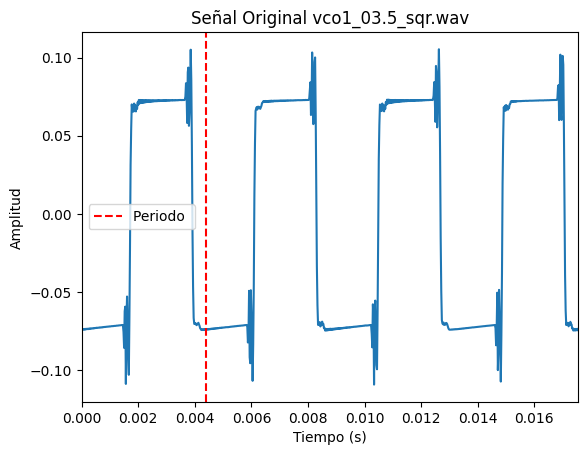

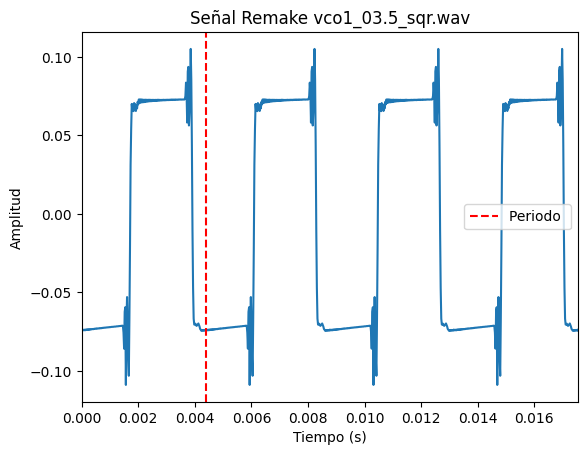

Similitud coseno entre MFCC, media = 0.9893
Diferencia espectral entre las señales = 0.9962950944900513
Mean Square Error = 0.009455


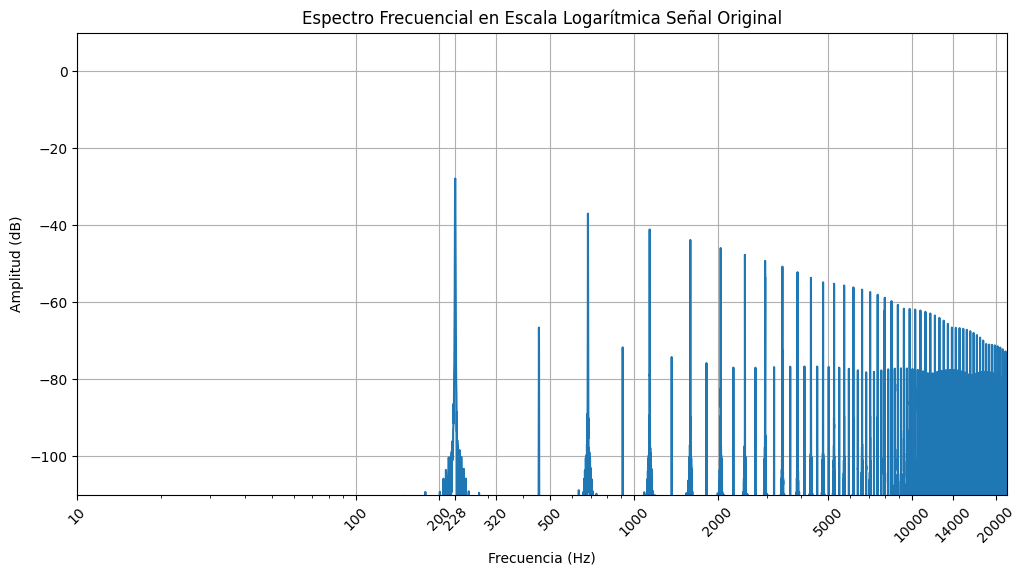

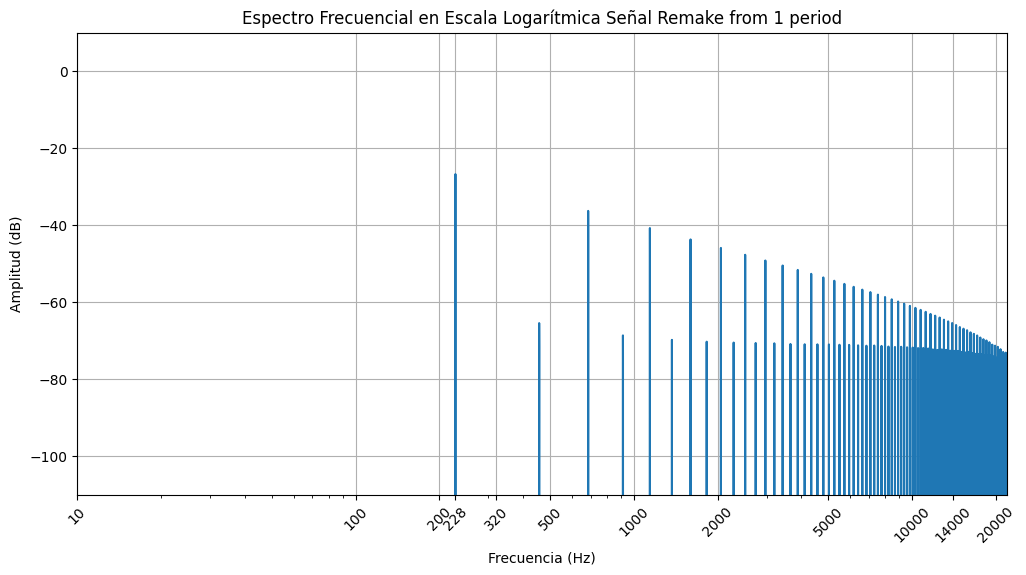

In [6]:
# Deshabilitar temporalmente las advertencias
warnings.filterwarnings('ignore')

input_file = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square/vco1_03.5_sqr.wav'

file_name = input_file.split("/")[-1]


audio, sampleRate = librosa.load(input_file, sr=48000)

audio_cut, num_periods, period = cut_audio_one_period(audio, sampleRate, file_name)
audio_remake = remake_audio_frome_period(audio_cut, num_periods)

# Calcular la duración total de la señal
total_time = len(audio_remake) / sampleRate

# Definir los límites del eje x como un rango que cubra 4 veces el período
x_lim = [0, 4 * period]
# Realizar el plot de la señal original
plt.plot(np.arange(len(audio)) / sampleRate, audio)
#plt.stem(np.arange(len(audio)) / sampleRate, audio, use_line_collection=True)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Original ' + file_name)
plt.axvline(x=period, color='r', linestyle='--', label='Periodo ')
# period_theoric = 1/freq_fund_teorica
# plt.axvline(x=period_theoric, color='g', linestyle='--', label='Periodo teórico')

plt.legend()
plt.xlim(x_lim)
plt.show()
# Realizar el plot de la señal remake
plt.plot(np.arange(len(audio_remake)) / sampleRate, audio_remake)
#plt.stem(np.arange(len(audio_remake)) / sampleRate, audio_remake, use_line_collection=True)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Remake ' + file_name)
plt.axvline(x=period, color='r', linestyle='--', label='Periodo ')
# period_theoric = 1/freq_fund_teorica
# plt.axvline(x=period_theoric, color='g', linestyle='--', label='Periodo teórico')

plt.legend()
plt.xlim(x_lim)
plt.show()


# Ejemplo de como visualizar  el espectro y marcar la freq. fundamental

# Plot del espectro de frecuencias
# plt.plot(frequencies[:len(frequencies)//2], 20 * np.log10(magnitude[:len(magnitude)//2]))
# plt.xlabel("Frecuencia (Hz)")
# plt.ylabel("Amplitud (dB)")
# plt.xlim([0, sampleRate/2])
# plt.ylim([-60, 30])

# plt.axvline(x=freq_fund_calculada, color='r', linestyle='--', label='Frecuencia fundamental: ' + str(freq_fund_calculada))
# plt.legend()
# plt.show()



ipd.display(ipd.Audio(data=audio, rate=sampleRate))
ipd.display(ipd.Audio(data=audio_remake, rate=sampleRate))

similitud_value = similitud_coseno_MFCC(audio, audio_remake, sampleRate)
dif_espec = comparar_frecuencias(audio, audio_remake, sampleRate)
MSE = compare_audio_MSE(audio, audio_remake)


print("Similitud coseno entre MFCC, media = "+str(similitud_value))
print("Diferencia espectral entre las señales = "+str(dif_espec))
print("Mean Square Error = "+str(MSE))




def plot_espectro_log(audio, sr, signal_tag):

    fig = plt.figure(figsize=(12, 6)) # create a figure with custom size
    
    plt.magnitude_spectrum(audio, Fs=sr, scale='dB')
    plt.title('Espectro Frecuencial en Escala Logarítmica Señal ' + signal_tag)
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Amplitud (dB)')
    plt.grid()
    plt.xlim([10, 22000]) # set the limits of the x axis
    plt.ylim([-110, 10]) # set the limits of the y axis
    plt.xscale('log')
    plt.xticks([10, 100, 200,228,320, 500, 1000, 2000, 5000, 10000, 14000, 20000], 
               ["10", "100", "200","228","320", "500", "1000", "2000", "5000", "10000", "14000", "20000"], 
               rotation=45) # set the location of the tick marks on the x axis
    
    plt.show()

plot_espectro_log(audio, sampleRate, 'Original')
plot_espectro_log(audio_remake, sampleRate, 'Remake from 1 period')
